Plotting for Omni-Paxos
===========================================

This notebook contains all the code for plotting the results. You can avoid most of the helper functions and nagivate directly to cells that will plot figures using the list below. To plot a figure, you will need to insert the path to the results directory.

- Partial Connectivity Experiments [E1]:
    - [Quorum-loss scenario](#quorumloss)
    - [Constrained scenario](#constrained)
    - [Chained scenario](#chained)
    
- Normal Experiments [E2-E4]: 
    - [Normal LAN (E2)](#normal-lan)
    - [Normal WAN \[E3, E4\]](#normal-wan)
    
- Reconfiguration Experiments [E5]:
    - [Single, CP=500](#reconfig-single-500)
    - [Single, CP=50k](#reconfig-single-50k)
    - [Majority, CP=50k](#reconfig-majority-50k)

### Dependencies

In [65]:
%matplotlib inline

# Importing the necessary libraries and modules
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import scipy.stats as st
from IPython.display import Image

### General styles and helper functions

In [66]:
def format_k(y, _):
    if y > 1000 or y < -1000:
        return "{}k".format(int(y/1000))
    else:
        return int(y)

def format_time(seconds, _):
    """Formats a timedelta duration to [N days] %M:%S format"""
    secs_in_a_min = 60

    minutes, seconds = divmod(seconds, secs_in_a_min)

    time_fmt = "{:d}:{:02d}".format(minutes, seconds)
    return time_fmt

In [67]:
colors = {
  "Omni-Paxos": "dodgerblue",
  "Omni-Paxos, n=3": "dodgerblue",
  "Omni-Paxos, n=5": "midnightblue", 
  "Omni-Paxos replace follower": "dodgerblue",
  "Omni-Paxos replace leader": "midnightblue",
  "Omni-Paxos 50ms": "dodgerblue",
  "Omni-Paxos 500ms": "lightskyblue",
  "Omni-Paxos 5000ms": "royalblue", 
  "Omni-Paxos 1 min": "dodgerblue",
  "Omni-Paxos 2 min": "lightskyblue",
  "Omni-Paxos 4 min": "royalblue",

  "Raft": "orange",
  "Raft replace follower": "orange",
  "Raft replace leader": "crimson",
  "Raft, n=3": "orange",
  "Raft, n=5": "crimson",
  "Raft 1 min": "silver",
  "Raft 2 min": "gray",
  "Raft 4 min": "black",
  "Raft 50ms": "silver",
  "Raft 500ms": "gray",
  "Raft 5000ms": "black",

  "Raft PV+CQ": "crimson",
  "Raft PV+CQ 1 min": "gold",
  "Raft PV+CQ 2 min": "orange",
  "Raft PV+CQ 4 min": "crimson",  
  "Raft PV+CQ 50ms": "gold",
  "Raft PV+CQ 500ms": "orange",
  "Raft PV+CQ 5000ms": "crimson",

  "Multi-Paxos, n=3": "lime",
  "Multi-Paxos, n=5": "darkgreen",
  "Multi-Paxos": "blueviolet",

  "Multi-Paxos 50ms": "pink",
  "Multi-Paxos 500ms": "mediumorchid",
  "Multi-Paxos 5000ms": "purple",
  "Multi-Paxos 1 min": "pink",
  "Multi-Paxos 2 min": "mediumorchid",
  "Multi-Paxos 4 min": "purple",

  "VR": "lime",
  "VR 50ms": "palegreen",
  "VR 500ms": "limegreen",
  "VR 5000ms": "darkgreen",
  "VR 1 min": "palegreen",
  "VR 2 min": "limegreen",
  "VR 4 min": "darkgreen",
}

linestyles = {
  "Omni-Paxos": "solid",
  "Raft": "dashdot",
  "Raft PV+CQ": "dashdot",
  "VR": "dotted",
  "Multi-Paxos": "dashed"
}

textures = {
  "50ms" : '\\',
  "500ms": '.',
  "5000ms": ''
  #patterns =['\\', '-', '/','+','//']
}

markers = {
  # deadlock plots
  "1 min": ".",
  "2 min": "v",
  "4 min": "s",
  "PV+CQ 1 min": ".",
  "PV+CQ 2 min": "v",
  "PV+CQ 4 min": "s",
  # reconfig plots
  "replace follower": ".",
  "replace leader": "v",
  # periodic plots
  "Omni-Paxos": ".",
  "Raft": "v" ,
  "Raft PV+CQ": "^",
  # normal plots
  " n=3": ".",
  " n=5": "v",
  # chained
  "1 min" : 'v',
  "2 min": 'o',
  "4 min": 's',
  # chained (updated)
  '50ms' : 'v',
  "500ms": 'o',
  "5000ms": 's'  
}

# Partial Connectivity <a id='another_cell'></a>

### Style and helper functions

In [68]:
BAR_WIDTH= 1
BAR_DIST = BAR_WIDTH
BASE = 4
GROUP_DIST = 10

TIMEOUTS = ["50ms","500ms","5000ms"]
DURATIONS = [60, 120, 240]

plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [69]:
def ci_init():
    return [(0,0) for _ in range(len(DURATIONS))]

In [70]:
# Dictionary to help structure the results to be plotted
def get_empty_dict():
    return {
        'paxos_1min' : (np.zeros(3), ci_init()),
        'raft_1min' : (np.zeros(3), ci_init()),
        'raft_pv_qc_1min' : (np.zeros(3), ci_init()),
        'vr_1min' : (np.zeros(3), ci_init()),
        'multi-paxos_1min' : (np.zeros(3), ci_init()),

        'paxos_2min' : (np.zeros(3), ci_init()),
        'raft_2min' : (np.zeros(3), ci_init()),
        'raft_pv_qc_2min' : (np.zeros(3), ci_init()),
        'vr_2min' : (np.zeros(3), ci_init()),
        'multi-paxos_2min' : (np.zeros(3), ci_init()),

        'paxos_4min' : (np.zeros(3), ci_init()),
        'raft_4min' : (np.zeros(3), ci_init()),
        'raft_pv_qc_4min' : (np.zeros(3), ci_init()),
        'vr_4min' : (np.zeros(3), ci_init()),
        'multi-paxos_4min' : (np.zeros(3), ci_init()),
    }

# The array for each entry in the dictionary should be sorted based on election timeout.
def get_timeout_idx(s):
    if s == '50ms':
        return 0
    elif s == '500ms':
        return 1
    elif s == '5000ms':
        return 2
    else:
        return -1
    
def get_dict_key(algo, scenario):
    split = scenario.split('-')
    duration = int(split[1])
    duration_min = int(duration/60)
    return "{}_{}min".format(algo, duration_min)

In [71]:
# calculate 95% confidence interval using student-t's distribution
def student_t_ci(data):
    return st.t.interval(alpha=0.95, df=len(data)-1,loc=np.mean(data),scale=st.sem(data))

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [72]:
# read results and insert into dict
def read_dir(d, decided, subdir, scenario, reverse):
    all_bars = get_empty_dict()
    d = '{}/{}'.format(d, subdir)
    data_files = [f for f in os.listdir(d) if f.endswith('.data') and scenario in f]
    data_files.sort()
    print("Reading: {} files in {}".format(len(data_files), d))
    for filename in data_files :
        f = open(d + "/" + filename, 'r')
        #print("Reading", filename, "...")
        # paxos,5,500,5min,off,none,constrained_election-240,500ms
        split = filename.split(',')
        algo = split[0]
        scenario = split[6]
        timeout = split[7].split('.')[0]
        all_y = []
        for line in f:
            if decided:
                y = float(line.split('|')[0])
            else:
                y = float(line)
            all_y.append(y)
        mean = np.mean(all_y)
        ci = student_t_ci(all_y)
        timeout_idx = get_timeout_idx(timeout)
        bar_key = get_dict_key(algo, scenario)
        (all_mean, all_ci) = all_bars[bar_key]
        all_mean[timeout_idx] = mean
        all_ci[timeout_idx] = ci
        
    all_1min = [("Omni-Paxos", all_bars['paxos_1min']), ("Raft", all_bars['raft_1min']), ("Raft PV+CQ", all_bars['raft_pv_qc_1min']), ("VR", all_bars['vr_1min']), ("Multi-Paxos", all_bars['multi-paxos_1min'])]
    all_2min = [("Omni-Paxos", all_bars['paxos_2min']), ("Raft", all_bars['raft_2min']), ("Raft PV+CQ", all_bars['raft_pv_qc_2min']), ("VR", all_bars['vr_2min']), ("Multi-Paxos", all_bars['multi-paxos_2min'])]
    all_4min = [("Omni-Paxos", all_bars['paxos_4min']), ("Raft", all_bars['raft_4min']), ("Raft PV+CQ", all_bars['raft_pv_qc_4min']), ("VR", all_bars['vr_4min']), ("Multi-Paxos", all_bars['multi-paxos_4min'])]
    if reverse:
        all_1min.reverse()
        all_2min.reverse()
        all_4min.reverse()
    if decided:
        all_groups = [("1 min", all_1min),("2 min", all_2min),("4 min", all_4min)]
    else:
        all_groups = [all_1min, all_2min, all_4min]
    return all_groups

In [73]:
WIDTH = 24
HEIGHT = 5
y_max_factor = 6
Y_LIMITS = [50*y_max_factor, 500*y_max_factor, 5000*y_max_factor]

In [74]:
def format_k_new(y, _):
    if y >= 1000 or y <= -1000:
        rest = int(y) % 1000
        #print(y, rest)
        if rest == 0:
            return "{}k".format(int(y/1000))
        else:           
            return "{:.1f}k".format(float(y/1000))
    else:
        return int(y)
    
def format_mil_new(y, _):
    if y >= 1000000 or y <= -1000000:
        rest = int(y) % 1000000
        #print(y, rest)
        if rest == 0:
            return "{}".format(int(y/1000000))
        else:           
            return "{:.1f}".format(float(y/1000000))
    else:
        return int(y)

In [75]:
# Dictionary to help structure the results to be plotted
def get_empty_algo_dict():
    return {
        'paxos' : (np.zeros(len(DURATIONS)), ci_init()),
        'raft' : (np.zeros(len(DURATIONS)), ci_init()),
        'raft_pv_qc' : (np.zeros(len(DURATIONS)), ci_init()),
        'vr' : (np.zeros(len(DURATIONS)), ci_init()),
        'multi-paxos' : (np.zeros(len(DURATIONS)), ci_init()),
    }

# The array for each entry in the dictionary should be sorted based on election timeout.
def get_duration_idx(s):
    if s == 60:
        return 0
    elif s == 120:
        return 1
    elif s == 240:
        return 2
    else:
        return -1

In [76]:
# read results and insert into dict
def read_timeout_dir(d, to_tp, subdir, scenario, timeout):
    all_bars = get_empty_algo_dict()
    d = '{}/{}'.format(d, subdir)
    data_files = [f for f in os.listdir(d) if f.endswith('.data') and scenario in f and timeout in f]
    data_files.sort()
    print("Reading: {} files in {}".format(len(data_files), d))
    #print(all_bars)
    for filename in data_files :
        f = open(d + "/" + filename, 'r')
        #print("Reading", filename, "...")
        # paxos,5,500,5min,off,none,constrained_election-240,500ms
        split = filename.split(',')
        algo = split[0]
        scenario = split[6]
        duration = int(scenario.split('-')[1])
        all_y = []
        for line in f:
            if to_tp:
                #y = float(line.split('|')[0])/duration
                y = float(line)/duration
            else:
                y = float(line)
            all_y.append(y)
        mean = np.mean(all_y)
        ci = student_t_ci(all_y)
        #print(mean, ci)
        duration_idx = get_duration_idx(duration)
        (all_mean, all_ci) = all_bars[algo]
        all_mean[duration_idx] = mean
        all_ci[duration_idx] = ci
        #print(all_bars[algo])
    
    a = [("Omni-Paxos", all_bars['paxos']), ("Raft", all_bars['raft']), ("Raft PV+CQ", all_bars['raft_pv_qc']), ("VR", all_bars['vr']), ("Multi-Paxos", all_bars['multi-paxos'])]
    return a

In [77]:
def plot_all_bars_new(ax, group, y_max, y_as_million):
    for i in range(len(group)):
        (algo, (algo_group, ci)) = group[i]
        base = (i+1)*BASE
        algo_group_len = len(algo_group)
        for j in range(algo_group_len):
            duration_s = DURATIONS[algo_group_len - j-1]
            #duration_s = DURATIONS[j]
            duration = "{} min".format(int(duration_s/60))
            label = "{} {}".format(algo, duration)
            bar_dist = (algo_group_len - j)*BAR_DIST
            
            y = algo_group[algo_group_len - j - 1] # convert ms to s
            x = base + bar_dist
            (ci_lo, ci_hi) = ci[algo_group_len - j-1]

            error_bar_color = "black"
            if colors[label] == "black":
                error_bar_color = "gray"
            #print(label, y, ci)
            if y > 0:
                ax.bar(x, y, align='edge', width=BAR_WIDTH, color=colors[label], alpha=0.95, yerr=(ci_hi-ci_lo)/2, ecolor = error_bar_color, error_kw = {"elinewidth": 3.5}, label=algo)

    #ax = plt.gca()
    #legend_without_duplicate_labels(ax)
    #plt.yscale("log")
    SIZE = 20
    #plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    #plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    #plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    # Deadlock line
    if y_max > 0:
        ax.axhline(y = y_max - y_max/10, color = 'r', linestyle = '--', linewidth=3)

    x_ticks = [15.5, 25.5, 35.5]
    #plt.xticks(x_ticks, TIMEOUTS)
    ax.tick_params(axis='y', which='major', labelsize=SIZE)
    #plt.ylabel("Down-time (s)", size=20)
    #plt.xlabel("Partition Duration", size=20)
    if y_as_million:
        ax.yaxis.set_major_formatter(format_mil_new)
    else:
        ax.yaxis.set_major_formatter(format_k_new)
    
    if y_max > 0:
        ax.set_ylim(top=y_max, bottom=0)
    
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

## Quorum-loss Scenario [E1] <a id='quorumloss'></a>

In [78]:
# Insert path to directory in meta_results here
# Example:
# QUORUMLOSS_DIR = "/home/username/omnipaxos-artifacts/meta_results/pc"
QUORUMLOSS_DIR = # INSERT PATH HERE

SyntaxError: invalid syntax (2779368449.py, line 4)

NameError: name 'QUORUMLOSS_DIR' is not defined

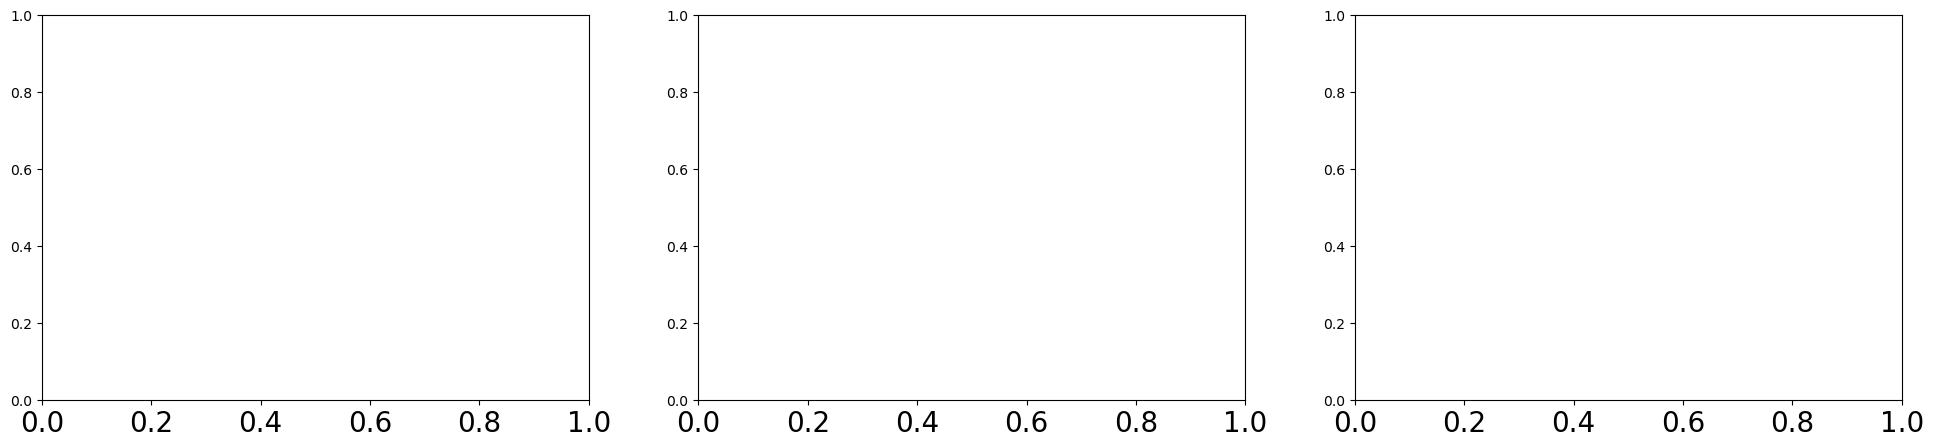

In [79]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(WIDTH, HEIGHT)
check_decided = False
subdir = "5-500-off/longest_down_time"
scenario = "quorum_loss"

for (idx, (timeout, y_lim)) in enumerate(zip(TIMEOUTS, Y_LIMITS)):
    all_same_timeout = read_timeout_dir(QUORUMLOSS_DIR, check_decided, subdir, scenario, timeout)
    plot_all_bars_new(ax[idx], all_same_timeout, y_lim, False)
    
plt.savefig("{}.pdf".format(scenario), dpi = 600, bbox_inches='tight')        

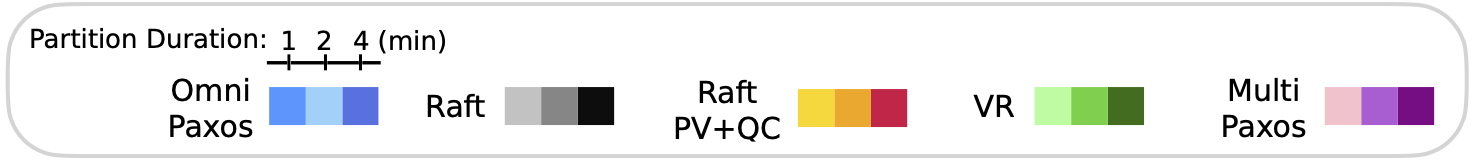

In [80]:
Image(filename='legend.png') 

## Constrained Scenario [E1] <a id='constrained'></a>

In [81]:
# Insert path to directory in meta_results here
# Example:
# CONSTRAINED_DIR = "/home/username/omnipaxos-artifacts/meta_results/pc"
CONSTRAINED_DIR = # INSERT PATH HERE

SyntaxError: invalid syntax (797757114.py, line 4)

Reading: 15 files in /Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/qloss-constrained-summary/meta_results/5-500-off/longest_down_time
Reading: 15 files in /Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/qloss-constrained-summary/meta_results/5-500-off/longest_down_time
Reading: 15 files in /Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/qloss-constrained-summary/meta_results/5-500-off/longest_down_time


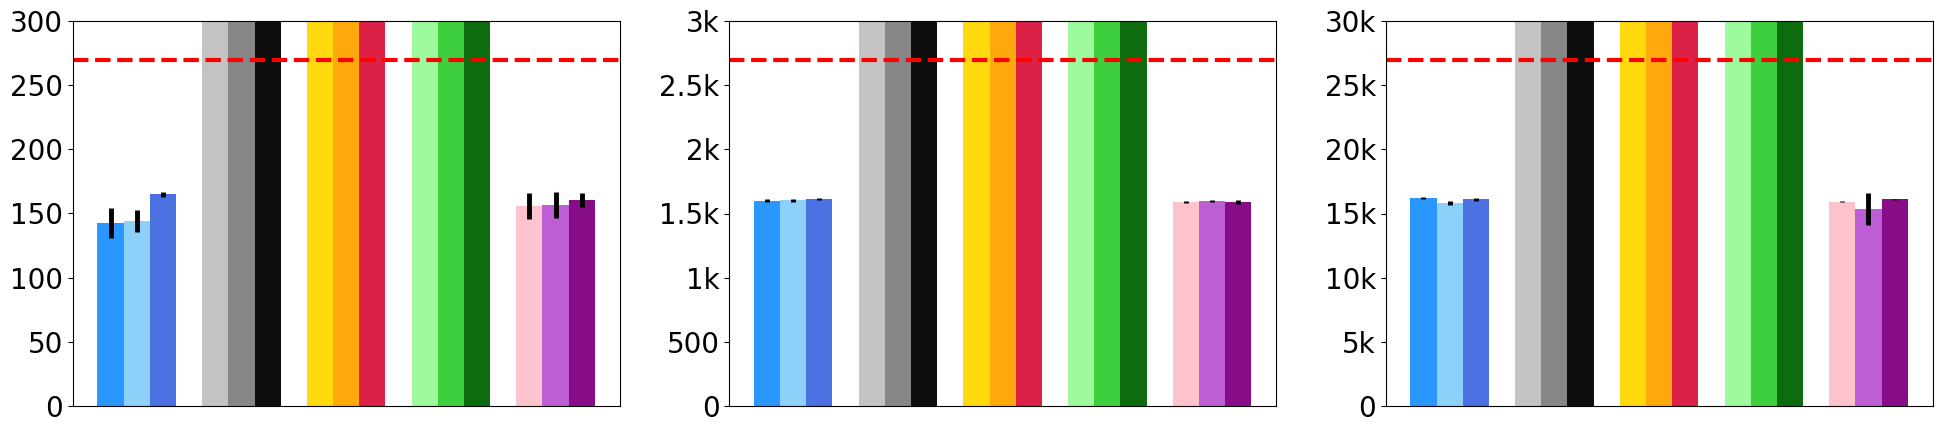

In [82]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(WIDTH, HEIGHT)
check_decided = False
subdir = "5-500-off/longest_down_time"
scenario = "constrained"

for (idx, (timeout, y_lim)) in enumerate(zip(TIMEOUTS, Y_LIMITS)):
    all_same_timeout = read_timeout_dir(CONSTRAINED_DIR, check_decided, subdir, scenario, timeout)
    #print(all_same_timeout)
    plot_all_bars_new(ax[idx], all_same_timeout, y_lim, False)
    
plt.savefig("{}.pdf".format(scenario), dpi = 600, bbox_inches='tight')    

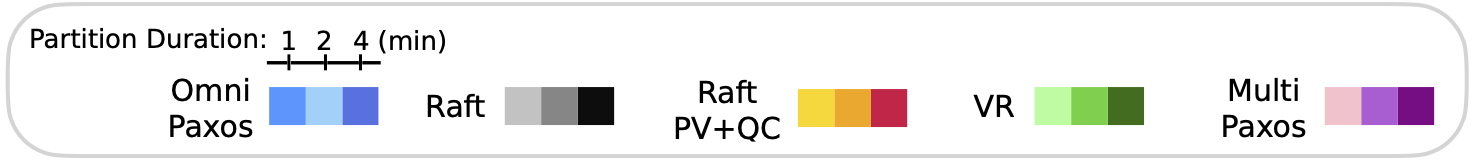

In [83]:
Image(filename='legend.png') 

In [84]:
# used to scale y-values 
MIO = 1000000

def plot_all_chained(all_groups):
    y_ticks = []
    y_labels = []
    for k in range(len(all_groups)):
        #group_base = (len(all_groups) - k - 1) * GROUP_DIST
        group_base = (k+1) * GROUP_DIST
        (partition_duration, group) = all_groups[k]
        for i in range(len(group)):
            (algo, (algo_group, ci)) = group[i]
            base = group_base % len(group) + (i+1)*BASE
            algo_group_len = len(algo_group)
            for j in range(algo_group_len):
                
                #duration_s = DURATIONS[algo_group_len - j-1]
                #duration = "{} min".format(int(duration_s/60))
                #label = "{} {}".format(algo, duration)
                #bar_dist = (algo_group_len - j)*BAR_DIST
                
                timeout = TIMEOUTS[j]
                duration_s = DURATIONS[k % len(DURATIONS)]
                duration = "{} min".format(int(duration_s/60))
                label = "{} {}".format(algo, duration)
                #bar_dist = (j)*BAR_DIST
                #y = algo_group[j]
                #x = base + bar_dist
                
                bar_dist = (j)*BAR_DIST
                x = algo_group[j]
                y = base + bar_dist
                #print(label, group_base, y)
                (ci_lo, ci_hi) = ci[j]
                if y > 0:
                    #plt.errorbar(x, y/MIO, yerr = (ci_hi/MIO-ci_lo/MIO)/2, color=colors[label], elinewidth=3, zorder=1)
                    #plt.scatter(x, y/MIO, color=colors[label], s=130, zorder=2, marker=markers[timeout], edgecolors="black")
                    plt.errorbar(x/MIO, y, xerr = (ci_hi/MIO-ci_lo/MIO)/2, color=colors[label], elinewidth=3, zorder=1)
                    #plt.scatter(x/MIO, y, color=colors[label], s=130, zorder=2, marker='.', edgecolors="black")
                    plt.scatter(x/MIO, y, color=colors[label], s=130, zorder=2, marker=markers[timeout], edgecolors="black")
                if j == 1:
                    y_ticks.append(y)
                    y_labels.append(algo)
                    
    SIZE = 20
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    #plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels

    plt.yticks(y_ticks, [])
    plt.tick_params(axis='x', which='major', labelsize=16)
    plt.xlabel("Number of Decided (million ops)", size=20)

## Chained Scenario [E1] <a id='chained'></a>

In [86]:
# Insert path to directory in meta_results here
# Example:
#CHAINED_DIR = "/home/username/omnipaxos-artifacts/meta_results/pc"
CHAINED_DIR = # INSERT PATH HERE

SyntaxError: invalid syntax (1770727082.py, line 4)

Reading: 0 files in /Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/chained-summary/meta_results/3-500-off/num_decided
Reading: 0 files in /Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/chained-summary/meta_results/3-500-off/num_decided
Reading: 0 files in /Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/chained-summary/meta_results/3-500-off/num_decided


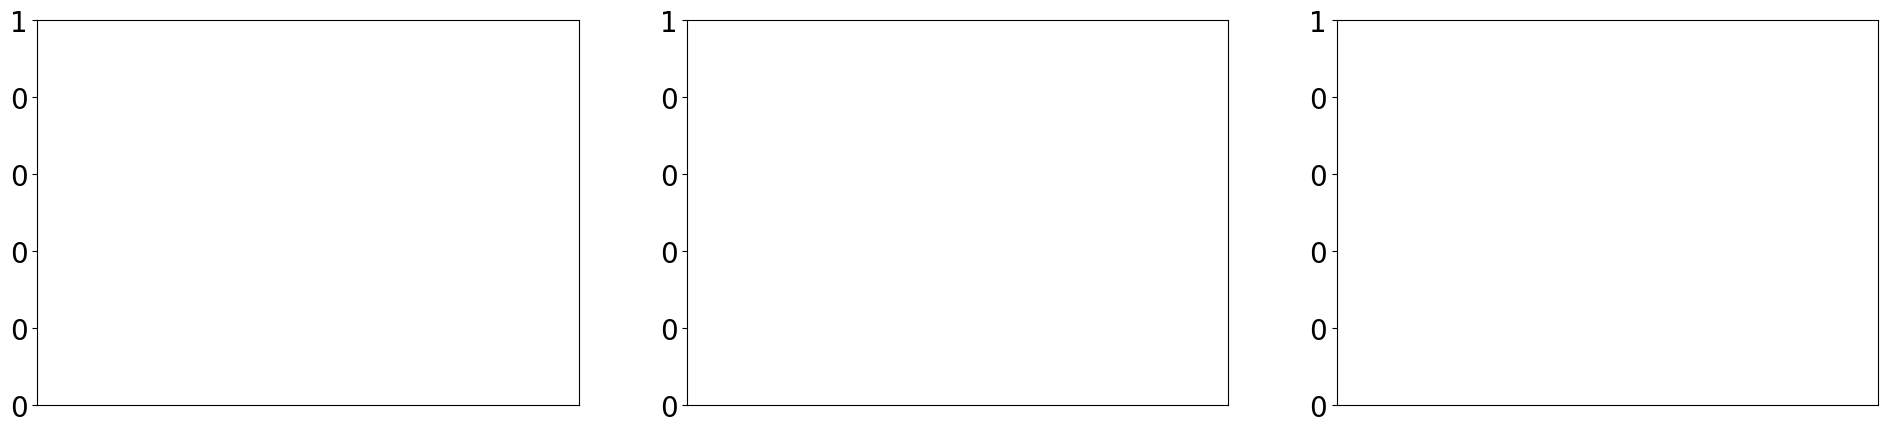

In [87]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(WIDTH-0.25, HEIGHT)
y_as_million = True
for (idx, (timeout, y_lim)) in enumerate(zip(TIMEOUTS, Y_LIMITS)):
    all_same_timeout = read_timeout_dir(CHAINED_DIR, False, sub_dir, scenario, timeout)
    plot_all_bars_new(ax[idx], all_same_timeout, 0, y_as_million)
    ax[idx].yaxis.set_tick_params(labelleft=True)  

plt.savefig("{}-decided.pdf".format(scenario), dpi = 600, bbox_inches='tight')    

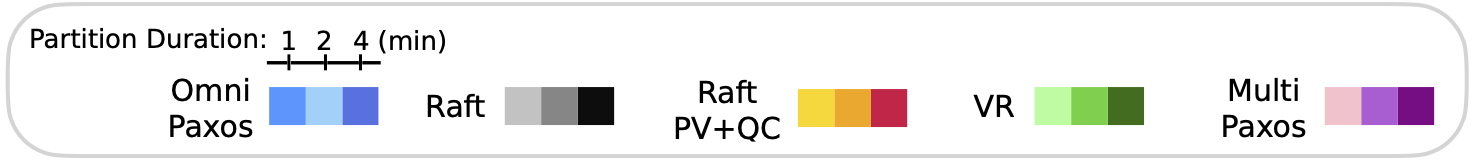

In [88]:
Image(filename='legend.png') 

# Normal

### Helper functions

In [89]:
def get_empty_dict_normal():
    return {
        'Omni-Paxos, n=3' : (np.zeros(3), np.zeros(3)),
        'Raft, n=3' : (np.zeros(3), np.zeros(3)),
        'Multi-Paxos, n=3' : (np.zeros(3), np.zeros(3)),
        
        'Omni-Paxos, n=5' : (np.zeros(3), np.zeros(3)),
        'Raft, n=5' : (np.zeros(3), np.zeros(3)),
        'Multi-Paxos, n=5' : (np.zeros(3), np.zeros(3)),
    }

def get_cp_idx(cp):
    if cp == 500:
        return 0
    elif cp == 5000:
        return 1
    else:
        return 2
    
def get_dict_key_normal(algo, num_nodes):
    if algo == "paxos":
        algo = "Omni-Paxos"
    elif algo == "multi-paxos":
        algo = "Multi-Paxos"
    elif algo == "raft" or algo == "raft_pv_qc":
        algo = "Raft"
    return "{}, n={}".format(algo, num_nodes)    

In [90]:
# Duration of normal experiments is 5 minutes.
EXP_DURATION = 5 * 60

def to_tp(num_decided):
    return num_decided/EXP_DURATION

def ci_to_err_tp(ci):
    (lo, hi) = ci
    (lo_tp, hi_tp) = (to_tp(hi), to_tp(lo))
    err = (hi_tp-lo_tp)/2
    return err

In [91]:
def read_normal_dir(all_series, p, use_only_leader):
    directories = [f.path for f in os.scandir(p) if f.is_dir()]
    for d in directories:
        decided_path = "{}/num_decided".format(d)
        data_files = [f for f in os.listdir(decided_path) if f.endswith('.data') and 'fully_connected' in f]
        for filename in data_files:
            f = open(decided_path + "/" + filename, 'r')
            print("Reading", filename, "...")
            # paxos,5,500,5min,off,none,constrained_election-240,500ms
            dir_split = filename.split(',')
            algo = dir_split[0]            
            num_nodes = int(dir_split[1])
            num_cp = int(dir_split[2])
            all_y = []
            for line in f:
                leader = int(line.split('|')[2])
                if use_only_leader == -1 or use_only_leader == leader:
                    num_decided = float(line.split('|')[0])
                    y = to_tp(num_decided)
                    all_y.append(y)
            if len(all_y) >= 1:        
                mean = np.mean(all_y)
                if len(all_y) > 1:
                    ci_decided = student_t_ci(all_y)
                    ci = ci_to_err_tp(ci_decided)
                else:
                    print('Could not plot CI! There was only one run with leader={}'.format(use_only_leader))
                    ci = 0
                cp_idx = get_cp_idx(num_cp)
                dict_key = get_dict_key_normal(algo, num_nodes)
                
                (all_mean, all_ci) = all_series[dict_key]
                all_mean[cp_idx] = mean
                all_ci[cp_idx] = ci
            else:
                print('Not enough data points to plot... there was probably not enough runs with leader={}'.format(use_only_leader))
        

In [92]:
x_axis = [1, 2, 3]
num_cp = ["500", "5k", "50k"]

def plot_normal(all_series):
    for (label, (data, ci)) in all_series.items():
        color = colors[label]
        split = label.split(",")
        linestyle = linestyles[split[0]]
        marker = markers[split[1]]
        plt.errorbar(x_axis, data, label=label, color=color, marker=marker, linestyle=linestyle, yerr=ci, capsize=8)
        
    ax = plt.gca()
    ax.yaxis.set_major_formatter(format_k)
    ax.legend(loc = "lower right", fontsize=13, ncol=1)
    #ax.legend()
    #fig.set_size_inches(15, 3.5)
    ax.set_ylabel('Throughput (ops/s)')
    ax.set_xlabel('Number of concurrent proposals')
    ax.set_ylim(bottom=0)
    plt.xticks(x_axis, num_cp)
    #plt.yticks(np.arange(0, 175000, 25000).tolist())
    #ax.set_ylim(bottom=0)


## Normal LAN [E2] <a id='normal-lan'></a>

In [93]:
# Insert path to directory in meta_results here
# Example:
# NORMAL_LAN_DIR = "/home/username/omnipaxos-artifacts/meta_results/normal-lan"
NORMAL_LAN_DIR = # INSERT PATH HERE

SyntaxError: invalid syntax (1485839157.py, line 4)

In [94]:
all_lan_series = get_empty_dict_normal()
any_leader = -1
#all_series = read_normal_dir(all_series, NORMAL_LAN_DIR, any_leader)
read_normal_dir(all_lan_series, NORMAL_LAN_DIR, any_leader)
plot_normal(all_lan_series)

NameError: name 'NORMAL_LAN_DIR' is not defined

## Normal WAN [E3, E4] <a id='normal-wan'></a>

In [95]:
# Insert path to directory in meta_results here
# Example:
# NORMAL_WAN3_DIR = "/home/username/omnipaxos-artifacts/meta_results/normal-wan3"
# NORMAL_WAN5_DIR = "/home/username/omnipaxos-artifacts/meta_results/normal-wan5"
NORMAL_WAN3_DIR = # INSERT PATH HERE
NORMAL_WAN5_DIR = # INSERT PATH HERE

SyntaxError: invalid syntax (2664804301.py, line 5)

In [96]:
all_wan_series = get_empty_dict_normal()
#print(all_series)
wan3_leader = 3
#all_series = read_normal_dir(all_series, NORMAL_WAN3_DIR, wan3_leader)
read_normal_dir(all_wan_series, NORMAL_WAN3_DIR, wan3_leader)
#print(all_series)

wan5_leader = 5
#all_series = read_normal_dir(all_series, NORMAL_WAN5_DIR, wan5_leader)
read_normal_dir(all_wan_series, NORMAL_WAN5_DIR, wan5_leader)
plot_normal(all_wan_series)

NameError: name 'NORMAL_WAN3_DIR' is not defined

# Reconfiguration

In [97]:
WINDOW_DURATION = 5
PLOT_CI = True

In [98]:
def get_label_and_color(filename):
    csv = filename.split(",")
    algorithm = csv[0]
    if algorithm == "paxos":
        algorithm = "Omni-Paxos"
    else:
        algorithm = "Raft"
    reconfig = csv[5]
    if reconfig == "none":
        label = algorithm
    else:
        label = "{} {}".format(algorithm, reconfig.replace("-", " "))
    color = colors[label]
    return (label, color)

def get_linestyle_and_marker(label):
    split = label.split(" ", 1)
    algo = split[0]
    duration = split[1]
    linestyle = linestyles[algo]
    marker = markers[duration]
    return (linestyle, marker)

In [99]:
y_axis = np.arange(0, 170000, 25000)

def plot_tp_windows(p, sub_dir, show_legend):
    max_ts = 0
    #print(p)
    p = '{}/{}/{}'.format(p, sub_dir, 'windowed')
    data_files = [f for f in os.listdir(p) if f.endswith('.data') and 'replace' in f]
    data_files.sort()
    for filename in data_files:
        f = open(p + "/" + filename, 'r')
        print("Reading", filename, "...")
        all_tp = []
        for line in f:
            
            #splitted = line.split('|')
            #assert len(splitted) == 2 # windows and number of warmup windows
            #num_decided_per_window = splitted[0].split(",")
            
            num_decided_per_window = line.split(",")
            #if filename != "raft,5,50000,20000000,majority,replace-follower.data":
                #del num_decided_per_window[-5:]
            if len(num_decided_per_window) < 2:
                continue
            for window_idx, num_decided in enumerate(num_decided_per_window):
                if num_decided.isdigit():
                    tp = int(num_decided) / WINDOW_DURATION
                    if len(all_tp) <= window_idx:
                        all_tp.append([])
                    all_tp[window_idx].append(tp)

        all_ts = []
        all_avg_tp = []
        all_ci95_lo = []
        all_ci95_hi = []

        all_min_tp = []
        all_max_tp = []

        all_tp_filtered = list(filter(lambda x: len(x) == 10, all_tp))
        #print(len(all_tp_filtered))
        for (window_idx, all_tp_per_window) in enumerate(all_tp_filtered):
            ts = (window_idx+1) * WINDOW_DURATION
            if ts > max_ts:
                max_ts = ts
            all_ts.append(ts)
            #all_ts.append(format_time(seconds=(i+1) * WINDOW_DURATION))
            avg_tp = sum(all_tp_per_window)/len(all_tp_per_window)
            all_avg_tp.append(avg_tp)

            min_tp = min(all_tp_per_window)
            max_tp = max(all_tp_per_window)
            all_min_tp.append(min_tp)
            all_max_tp.append(max_tp)
            
            if PLOT_CI:
                if (sum(all_tp_per_window) > 0 and len(all_tp_per_window) > 1):
                    (ci95_lo, ci95_hi) = student_t_ci(all_tp_per_window)
                    if ci95_lo < 0:
                        ci95_lo = 0
                    all_ci95_lo.append(ci95_lo)
                    all_ci95_hi.append(ci95_hi)
                else:
                    all_ci95_lo.append(all_tp_per_window[0])
                    all_ci95_hi.append(all_tp_per_window[0])
                    
        (label, color) = get_label_and_color(filename)
        (linestyle, marker) = get_linestyle_and_marker(label)
        plt.plot(all_ts, np.array(all_avg_tp), color=color, label=label, linestyle=linestyle, marker=marker),
        if PLOT_CI:
            plt.fill_between(all_ts, all_ci95_lo, all_ci95_hi, color=color, alpha=0.2)
   
    ax = plt.gca()
    MEDIUM_SIZE = 18
    x_axis = np.arange(0, max_ts+4*WINDOW_DURATION, 4*WINDOW_DURATION)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(MEDIUM_SIZE)

    if show_legend:
        ax.legend(loc = "upper center", fontsize=8, ncol=2)

        
    plt.xlabel("Time")
    plt.xticks(x_axis)
    plt.yticks(y_axis)
    #plt.ylim(top=165000)
    
    ax.xaxis.set_major_formatter(format_time)
    ax.yaxis.set_major_formatter(format_k)

    plt.ylim(bottom=0)
    plt.gcf().autofmt_xdate()
    plt.ylabel("Throughput (ops/s)")

## Reconfiguration - Single server, CP=500 [E5] <a id='reconfig-single-500'></a>

In [100]:
# Insert path to directory in meta_results here
# Example:
# RECONFIG_SINGLE_CP500 = "/home/username/omnipaxos-artifacts/meta_results/reconfig"
RECONFIG_SINGLE_CP500 = # INSERT PATH HERE
SHOW_LEGEND = True

SyntaxError: invalid syntax (3839198845.py, line 4)

In [101]:
sub_dir = "5-500-single"
plot_tp_windows(RECONFIG_SINGLE_CP500, sub_dir, SHOW_LEGEND)

Reading paxos,5,500,20000000,majority,replace-follower.data ...


KeyError: 'Omni-Paxos replace follower.data'

## Reconfiguration - Single server, CP=50k [E5] <a id='reconfig-single-50k'></a>

In [102]:
# Insert path to directory in meta_results here
# Example:
# RECONFIG_SINGLE_CP50K = "/home/username/omnipaxos-artifacts/meta_results/reconfig"
RECONFIG_SINGLE_CP50K = # INSERT PATH HERE
SHOW_LEGEND = False

SyntaxError: invalid syntax (672743946.py, line 4)

In [103]:
sub_dir = "5-50000-single"
plot_tp_windows(RECONFIG_SINGLE_CP50K, sub_dir, SHOW_LEGEND)

NameError: name 'RECONFIG_SINGLE_CP50K' is not defined

## Reconfiguration - Majority, CP=50k [E5] <a id='reconfig-majority-50k'></a>

In [104]:
# Insert path to directory in meta_results here
# Example:
# RECONFIG_MAJORITY_CP50K = "/home/username/omnipaxos-artifacts/meta_results/reconfig"
RECONFIG_MAJORITY_CP50K = # INSERT PATH HERE
SHOW_LEGEND = False

SyntaxError: invalid syntax (438554129.py, line 4)

In [105]:
sub_dir = "5-50000-majority"
plot_tp_windows(RECONFIG_MAJORITY_CP50K, sub_dir, SHOW_LEGEND)

NameError: name 'RECONFIG_MAJORITY_CP50K' is not defined